<a href="https://colab.research.google.com/github/lbuerger/IANNwTF/blob/main/homework5/hw5_201130.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time 

In [3]:
# load data and only use the 'train' part of it
load = tf.keras.datasets.cifar10.load_data()
print("train images",load[0][0].shape)
print("train labels",load[0][1].shape)
print("test images",load[1][0].shape)
print("test labels",load[1][1].shape)

train images (50000, 32, 32, 3)
train labels (50000, 1)
test images (10000, 32, 32, 3)
test labels (10000, 1)


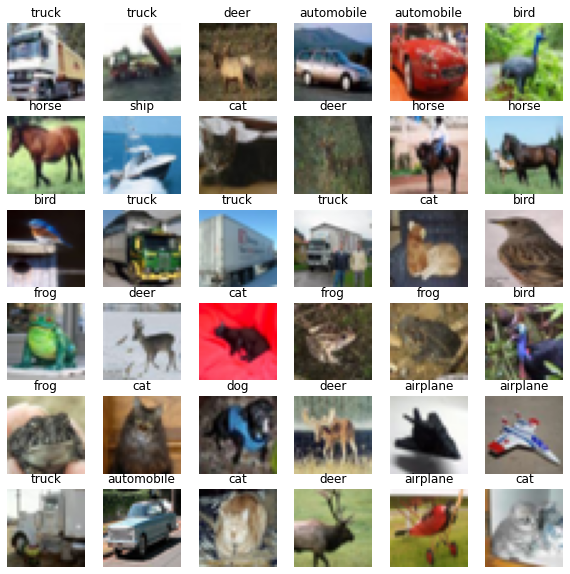

In [4]:
# plot the first entries to get an idea of the data
fig = plt.figure(figsize=(10,10))
class_names={0:'airplane',1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse',8:'ship', 9:'truck'}
for i in range(1,37):
  img = load[0][0][i]
  fig.add_subplot(6,6,i)
  
  plt.imshow(img)
  plt.axis('off')  
  # the label is 0 if the image contains malaria and 1 if it does not
  plt.title( str(class_names[int(load[0][1][i])]))

fig.show()

In [5]:
def preprocess_img(image):
  """
  normalize between 0 and 1
  """
  max = tf.math.reduce_max(image)
  min = tf.math.reduce_min(image)
  image = (image - min) / (max - min)
  return image

In [6]:
# Train dataset
ds_train_img = tf.data.Dataset.from_tensor_slices(load[1][0])
ds_train_img = ds_train_img.map(lambda img: preprocess_img(img))
ds_train_label = tf.data.Dataset.from_tensor_slices(load[1][1])
ds_train_label = ds_train_label.map(lambda label: tf.one_hot(label, 10)[0])
ds_train = tf.data.Dataset.zip((ds_train_img, ds_train_label))
#ds_train = ds_train.batch(64).shuffle(buffer_size=64)

# test dataset
ds_tst_img = tf.data.Dataset.from_tensor_slices(load[1][0])
ds_tst_img = ds_tst_img.map(lambda img: preprocess_img(img))
ds_tst_label = tf.data.Dataset.from_tensor_slices(load[1][1])
ds_tst_label = ds_tst_label.map(lambda label: tf.one_hot(label, 10)[0])
ds_tst = tf.data.Dataset.zip((ds_tst_img, ds_tst_label))
#ds_tst = ds_tst.batch(64).shuffle(buffer_size=64)

print(ds_train)
print(ds_tst)

<ZipDataset shapes: ((32, 32, 3), (10,)), types: (tf.float32, tf.float32)>
<ZipDataset shapes: ((32, 32, 3), (10,)), types: (tf.float32, tf.float32)>


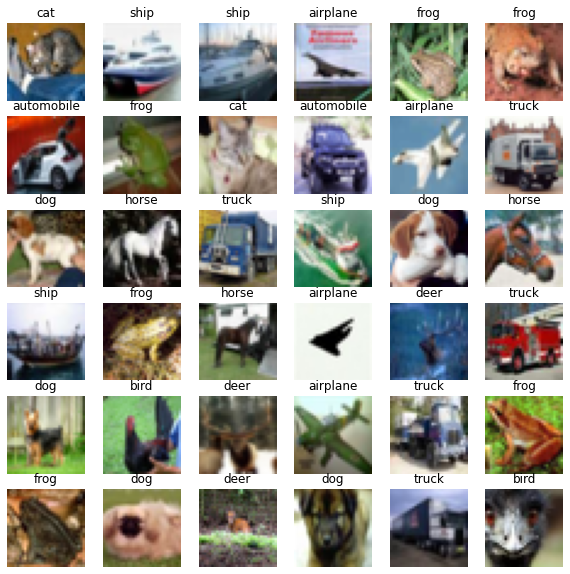

In [7]:
# re-plot the first nine entries after the mapping
def one_hot_to_int(one_hot):
  """
  reverse one hot function returning the int to the one hot vector
  """
  count = 0
  for entry in one_hot:
    if entry:
      break
    count += 1
  return count

count = 0
fig = plt.figure(figsize=(10,10))
class_names={0:'airplane',1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse',8:'ship', 9:'truck'}
for img in ds_train:
  count += 1
  fig.add_subplot(6,6,count)
  #print(img[0].numpy())
  plt.imshow(img[0])
  plt.axis('off')
  plt.title(class_names[one_hot_to_int(img[1])])
  if count == 36:
    break;
fig.show()

In [8]:
# perf batching, shuffeling and prefetching
train_ds = ds_train.batch(256).shuffle(buffer_size=256).prefetch(4)
test_ds = ds_tst.batch(256).shuffle(buffer_size=256).prefetch(4)

In [9]:
# to check the shape (here: 64 batch size and a 32x32 image with 3 colours)
for (img,_) in test_ds:
    print(img.shape)
    break;

(256, 32, 32, 3)


In [25]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the five layers based on the flipped classroom example
        # using only 3x3 kernels and 2x2 max pooling
        self.conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                               activation=None,
                                               input_shape=(32,32,3)
                                               )
        self.max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                               activation=None,
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=3,
                                               activation=None,
                                                )


        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer = tf.keras.layers.Dense(10,
                                                  activation=tf.keras.activations.softmax)
        
        self.relu = tf.keras.activations.relu
        self.batch_norm = tf.keras.layers.BatchNormalization()


    def call(self, x, training=True):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.batch_norm(x, training)
        x = self.relu(x)
        x = self.max_pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_norm(x, training)
        x = self.relu(x)
        x = self.max_pool_2(x)

        x = self.conv_3(x)
        x = self.batch_norm(x, training)
        x = self.relu(x)
        x = self.global_pool(x)
        x = self.output_layer(x)
        return x

In [26]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training=training)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  

In [27]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 40
learning_rate = 0.00005
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Using categorical crossentropy due to 10 classes
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss, training=False)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print(model.summary())
print("Pre-learning")
print('test loss:', round(test_loss,4), 'acc:', round(test_accuracy,6))

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss, training=False)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))
    time1 = time.time()
    train_ds = train_ds.shuffle(buffer_size=128)
    test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss, training=False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('test loss:', round(test_loss,4), 'acc:', round(test_accuracy,6), "took", round((time.time()-time1),1),"sec")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  295168    
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2570  

KeyboardInterrupt: ignored

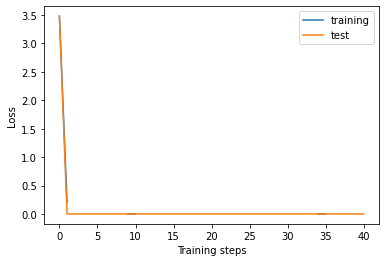

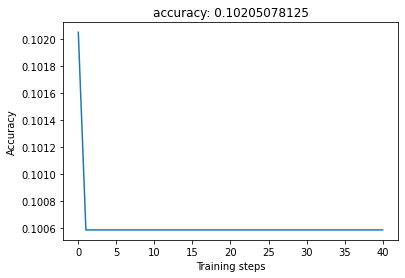

In [13]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()